<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#高斯混合模型的-EM-算法实现" data-toc-modified-id="高斯混合模型的-EM-算法实现-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>高斯混合模型的 EM 算法实现</a></span></li><li><span><a href="#使用-sklearn.mixture.GaussianMixture-类" data-toc-modified-id="使用-sklearn.mixture.GaussianMixture-类-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>使用 sklearn.mixture.GaussianMixture 类</a></span></li><li><span><a href="#参考文献" data-toc-modified-id="参考文献-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>参考文献</a></span></li></ul></div>

![title](EM.gif)

In [1]:
import numpy as np

In [2]:
class ThreeCoinsEM:
    def __init__(self, pi, p, q, threshold):
        self.pi = pi #A 模型，正面朝上概率
        self.p = p #B 模型，正面朝上概率
        self.q = q #C 模型，正面朝上概率
        self.threshold = threshold # 算法停止阈值
    
    # 依据当前模型参数，计算 B 模型对观测数据 y 的响应度，即依据 y 测算选择 B 硬币的概率
    def CalcResponse(self, Y):
        prob_b = self.pi * np.power(self.p, Y) * np.power(1 - self.p, np.ones(len(Y)) - Y)
        prob_c = (1 - self.pi) * np.power(self.q, Y) * np.power(1 - self.q, np.ones(len(Y)) - Y)
        return prob_b / (prob_b + prob_c)
    
    # 执行 E-step 和 M-step
    def fit(self, Y):
        while (True):
            # 执行 E-step
            response = self.CalcResponse(Y)
            # 执行 M-step
            new_pi = np.mean(response)
            new_p = np.dot(response, Y) / np.sum(response)
            new_q = np.dot(1 - response, Y) / np.sum(1 - response)
            #EM 算法停止条件
            max_error = max(abs(new_pi - self.pi), abs(new_p - self.p),
            abs(new_q - self.q))
            self.pi = new_pi
            self.p = new_p
            self.q = new_q
            if max_error < self.threshold:
                break
        print(self.pi, self.p, self.q)
        print('Three-Coins model training completed!')

In [3]:
 Y = [1, 1, 0, 1, 0, 0, 1, 0, 1, 1]

em = ThreeCoinsEM(0.5, 0.5, 0.5, 1e-6)
em.fit(Y)

In [4]:
em = ThreeCoinsEM(0.4, 0.6, 0.7, 1e-6)
em.fit(Y)

0.40641711229946526 0.5368421052631578 0.6432432432432433
Three-Coins model training completed!


# 高斯混合模型的 EM 算法实现

In [5]:
from scipy.stats import multivariate_normal
import copy

In [6]:
class GaussianMixtureEM:
    def __init__(self, K, threshold):
        self.K = K
        self.threshold = threshold
    
    def CalcResponse(self, Y):
        for k in range(self.K):
            self.response[k] = self.alpha[k] * multivariate_normal.pdf(
                Y, mean=self.mu[k], cov=self.cov[k])
        self.response = self.response / np.sum(self.response, axis= 0)
    
    def fit(self, Y):
        # 参数初始化
        N, D = Y.shape
        self.alpha = np.random.rand(self.K)
        self.alpha = self.alpha / np.sum(self.alpha)
        self.mu = np.random.rand(self.K, D)
        self.cov = np.empty((self.K, D, D))
        for k in range(self.K): # 随机生成协方差矩阵，必须是半正定矩阵
            self.cov[k] = np.eye(D) * np.random.rand() * self.K
        self.response = np.zeros((self.K, N))
        # 保存参数，用于生成动画
        self.paras = [(copy.deepcopy(self.mu), copy.deepcopy(self.cov))]
        while (True):
            # 执行 E-step
            self.CalcResponse(Y)
            # 执行 M-step
            old_alpha = copy.deepcopy(self.alpha)
            old_mu = copy.deepcopy(self.mu)
            old_cov = copy.deepcopy(self.cov)
            r = np.sum(self.response, axis = 1) # 每个分模型的响应度
            for k in range(self.K): # 遍历每个分模型
                self.mu[k] = np.dot(self.response[k], Y) / r[k]
                self.cov[k] = np.dot(self.response[k] * (Y - self.mu[k]).T,
                                     (Y - self.mu[k])) / r[k]
            self.alpha = r / N
            # 保存参数，用于生成动画
            self.paras.append((copy.deepcopy(self.mu), copy.deepcopy(self.cov)))
            if max(np.abs(self.alpha - old_alpha).max(), 
                   np.abs(self.mu - old_mu).max(), 
                   np.abs(self.cov - old_cov).max()) < self.threshold:
                break
        print('alpha:', self.alpha)
        print('\nGaussian mixture model training completed!')

In [7]:
with open('points.dat') as file:
    allines = file.readlines()
Y = np.array([line.strip().split() for line in allines]).astype(np.float32)[:500]

In [8]:
gm = GaussianMixtureEM(4, 1e-3)
gm.fit(Y)

alpha: [0.17815979 0.36967667 0.14168334 0.31048021]

Gaussian mixture model training completed!


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# 本函数来源于 matplotlib.mlab，在较新版本中被禁用
# 单独列出，供使用
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0, mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy
    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

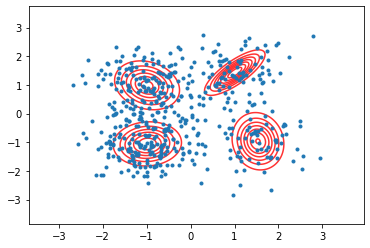

In [11]:
%matplotlib inline

plt.plot(Y[:, 0], Y[:, 1], '.')
# 生成绘图用的网格
x0_min, x0_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
x1_min, x1_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1

xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))
for k in range(gm.K):
    xx2 = bivariate_normal(xx0, xx1, gm.cov[k, 0, 0], gm.cov[k, 1, 1],
                           gm.mu[k, 0], gm.mu[k, 1], gm.cov[k, 0, 1])
    # 检验数组元素是否都是有效数据，避免绘制 contour 时出现警告信息
    if np.isnan(xx2).sum() == 0:
        plt.contour(xx0, xx1, xx2, colors = 'r', alpha = 0.8)

<IPython.core.display.Javascript object>


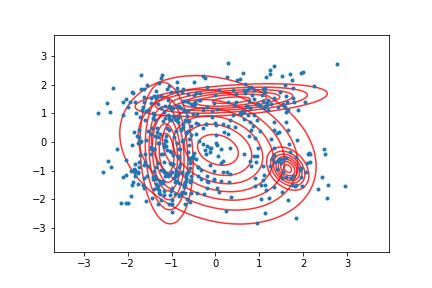

In [19]:
import matplotlib.animation as animation
from IPython.display import HTML
# 动画播放，如果是%matplotlib inline，则会嵌入图片
%matplotlib notebook
fig = plt.figure()

# 生成绘图用的网格
x0_min, x0_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
x1_min, x1_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),np.arange(x1_min, x1_max, 0.02))
ax = plt.axes(xlim=(x0_min, x0_max), ylim=(x1_min, x1_max))
ax.plot(Y[:, 0], Y[:, 1], '.')

def update(para):
    ax.collections = [] # 清除原有的图元对象
    mu, cov = para[0], para[1]
    for k in range(gm.K):
        xx2 = bivariate_normal(xx0, xx1, cov[k, 0, 0], cov[k, 1, 1],
                               mu[k, 0], mu[k, 1], cov[k, 0, 1])
    # 检验数组元素是否都是有效数据，避免绘制 contour 时出现警告信息
        if np.isnan(xx2).sum() == 0:
            contour = ax.contour(xx0, xx1, xx2, colors = 'r', alpha = 0.8)
    return ax.collections

ani = animation.FuncAnimation(fig, update, gm.paras)

In [13]:
np.seterr(divide = 'ignore', invalid = 'ignore')
ani.save('EM_fitting.mp4')

# 使用 sklearn.mixture.GaussianMixture 类

In [14]:
from sklearn.mixture import GaussianMixture

In [15]:
n_components = 4
skgm = GaussianMixture(n_components)
skgm.fit(Y)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

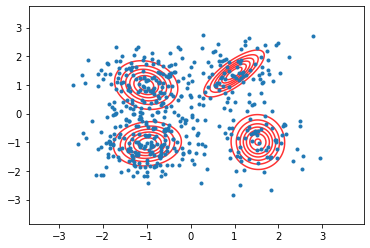

In [16]:
%matplotlib inline

plt.plot(Y[:, 0], Y[:, 1], '.')
# 生成绘图用的网格
x0_min, x0_max = Y[:, 0].min() - 1, Y[:, 0].max() + 1
x1_min, x1_max = Y[:, 1].min() - 1, Y[:, 1].max() + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, 0.02),
                       np.arange(x1_min, x1_max, 0.02))
for k in range(n_components):
    xx2 = bivariate_normal(xx0, xx1, skgm.covariances_[k, 0, 0], 
                           skgm.covariances_[k, 1, 1],skgm.means_[k, 0],
                           skgm.means_[k, 1], skgm.covariances_[k, 0, 1])
    # 检验数组元素是否都是有效数据，避免绘制 contour 时出现警告信息
    if np.isnan(xx2).sum() == 0:
        plt.contour(xx0, xx1, xx2, colors = 'r', alpha = 0.8)

# 参考文献

[1] https://github.com/wzyonggege/statistical-learning-method;

[2] 李航。《统计学习方法》，清华大学出版社， 2012 年 3 月第 1 版；